In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets

## Dataset

In [3]:
PATH_TO_DATA_FOLDER = "../../../Dataset time-series/data/Yemen/"

In [4]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [5]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [6]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [7]:
TEST_SIZE = 30
FREQ = train.index.freq

In [8]:
# In order to predict using the naive model only the fcs data are need.
train_target = train.xs("FCS", axis = 1, level = 1, drop_level = False)

In [9]:
PROVINCES = train_target.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [10]:
# Plot time-series.
#TsIP(train_target).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

In [11]:
# Recovering the training sets and test sets.
TRAIN_TARGET_SETS = find_multiple_sets(train_target)
TEST_TARGET_SETS = find_multiple_sets(test)

## kNN-TSPI

In [12]:
from kNN_TSPI import kNN_TSPI

In [15]:
l = 10
k = 3

In [25]:
FORECASTING = test.copy()
for PROVINCE in PROVINCES:
    print(PROVINCE)
    train_sets = [s[PROVINCE]["FCS"] for s in TRAIN_TARGET_SETS]
    for i, test_set in enumerate(TEST_TARGET_SETS):
        model = kNN_TSPI(l = l, k = k, h = TEST_SIZE, plot_nn_subsequence = False)
        # Coumpute prediction on this set.
        y_hats = model.predict(train_sets, i).values
        FORECASTING[(PROVINCE, "FCS")].loc[test_set.index] = y_hats

Abyan
Aden
Al Bayda
Al Dhale'e
Al Hudaydah
Al Jawf
Al Maharah
Al Mahwit
Amanat Al Asimah
Amran
Dhamar
Hajjah
Ibb
Lahj
Marib
Raymah
Sa'ada
Sana'a
Shabwah
Taizz


In [26]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [27]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [28]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    loss = mean_squared_error(test_set, forecasting_set)
    losses.append(loss)
    loss_h = mean_squared_error(test_set.transpose(), forecasting_set.transpose(), multioutput = "raw_values")    
    losses_h.append(loss_h)

In [29]:
np.mean(losses)

20.31768199464743

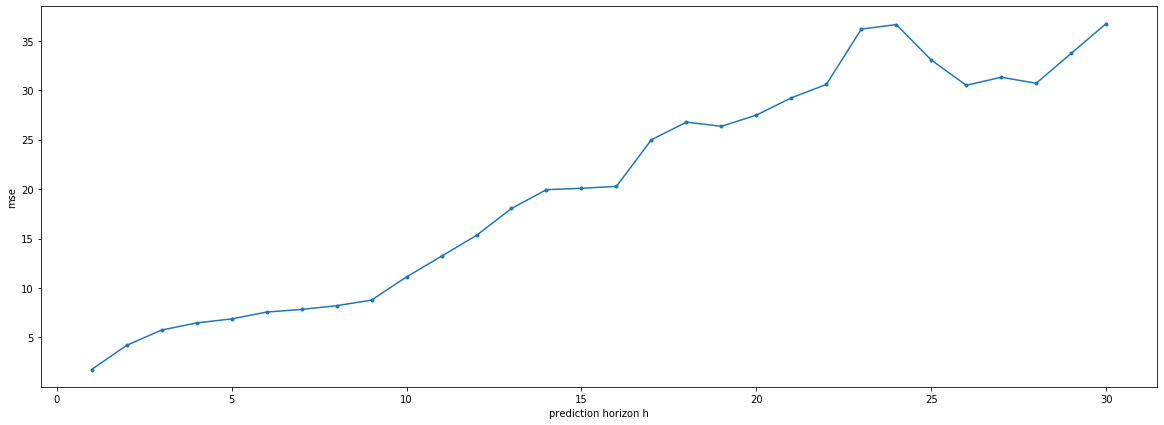

In [30]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10);